In [15]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
import shap

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


In [16]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")


# Polygons for mapping onto waves

In [17]:

## County Data 


data_by_county = pd.read_csv('/Users/rem76/Documents/COVID_projections/county_time_data_all_dates.csv')

data_by_county = data_by_county.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])
data_by_county['CTYNAME'] = data_by_county['CTYNAME'].apply(lambda x: x.split()[0])
data_by_county['CTYNAME'] = data_by_county['fips'].astype(str) + '' + data_by_county['CTYNAME']
data_by_county['beds_over_15_100k'] = (data_by_county['beds_weekly'] > 15) * 1

# Redo dates
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i

## DELTA POLYGON 

start_date = pd.to_datetime('2021-06-30')
end_date = pd.to_datetime('2021-10-26')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_delta = data_by_county.loc[matching_indices_start, 'week']
last_week_delta = data_by_county.loc[matching_indices_end, 'week']
start_date = pd.to_datetime('2021-10-26')
end_date = pd.to_datetime('2022-09-27')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_omricon = data_by_county.loc[matching_indices_start, 'week']
last_week_omricon = data_by_county.loc[matching_indices_end, 'week']

## CDC POLYGON 
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-01-24')
data_by_county['date'] = pd.to_datetime(data_by_county['date'])
for i, week in enumerate(data_by_county['date'].unique()):
    data_by_county.loc[data_by_county['date'] == week, 'week'] = i
# Find the indices of rows that match the exact start and end dates
matching_indices_start = data_by_county.loc[data_by_county['date'] <= start_date].index.max()
matching_indices_end = data_by_county.loc[data_by_county['date'] <= end_date].index.max()
first_week_CDC = data_by_county.loc[matching_indices_start, 'week']
last_week_CDC = data_by_county.loc[matching_indices_end, 'week']

Columns (47,48,49,50,51,55,56) have mixed types. Specify dtype option on import or set low_memory=False.


# Percent exceeding capacity 

In [32]:
percent_exceed_capacity = []

# Iterate through the columns of the DataFrame
for column_name in HSA_weekly_data_all.columns:
    if 'beds_over_15_100k' in column_name:
        # Calculate the sum of the column and append it to the list
        column_sum = HSA_weekly_data_all[column_name].sum()/len(HSA_weekly_data_all[column_name])
        percent_exceed_capacity.append(column_sum)

# Dictionaries to save data

In [18]:
model_metric_ROC = {}
model_metric_accuracy = {}
model_metric_MCC = {}

# Parameters for hyperparameter tuning 

In [23]:
no_iterations = 10
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'shifted'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  
no_iterations_param = 100  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations


# 4 weeks of data

In [25]:
weeks_to_predict_four_week = range(1, 121 - 1 - 3  - 1 - 4)

model_metric_ROC['ROC_by_week_full_period_4_week'] = []
model_metric_accuracy['accuracy_by_week_full_period_4_week'] = []
model_metric_MCC['norm_MCC_by_week_full_period_4_week'] = []


size_of_test_dataset = 1
for prediction_week in weeks_to_predict_four_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/4_week_models_incl_NA/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 4) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 4) + 1, int(prediction_week + 4 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_full_period_4_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_full_period_4_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_full_period_4_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111


# 10 weeks of data

In [26]:
weeks_to_predict_ten_week = range(1, 121 - 1 - 3 - 10 - 1)
model_metric_ROC['ROC_by_week_full_period_10_week'] = []
model_metric_accuracy['accuracy_by_week_full_period_10_week'] = []
model_metric_MCC['norm_MCC_by_week_full_period_10_week'] = []

#for i in range(0,11): # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_full_period_10_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_full_period_10_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_full_period_10_week'].append(0)

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_ten_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/10_week_models_incl_NA/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model



    model_metric_ROC['ROC_by_week_full_period_10_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_full_period_10_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_full_period_10_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106


# 26 weeks of data 

In [27]:
weeks_to_predict_twenty_six_week = range(1, 121 - 1 - 3 - 26 - 1) # 1 for the outcome week, 1 for the outcome period, 26 for the initial model, 1 for shifted

model_metric_ROC['ROC_by_week_full_period_26_week'] = []
model_metric_accuracy['accuracy_by_week_full_period_26_week'] = []
model_metric_MCC['norm_MCC_by_week_full_period_26_week'] = []

#for i in range(0,27):  # add one week to account for the initial training week 
#    model_metric_ROC['ROC_by_week_full_period_26_week'].append(0)
#    model_metric_accuracy['accuracy_by_week_full_period_26_week'].append(0)
#    model_metric_MCC['norm_MCC_by_week_full_period_26_week'].append(0)


size_of_test_dataset = 1
for prediction_week in weeks_to_predict_twenty_six_week:
    print(prediction_week)
    model_name_to_load = "/Users/rem76/Documents/COVID_projections/Expanding_full_model_shifted/Full_model_shifted_NA/26_week_models_incl_NA/Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()


    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)

    # Evaluate the accuracy of the model

    model_metric_ROC['ROC_by_week_full_period_26_week'].append(roc_auc_score(y_test_full_period, y_pred_proba[:, 1]))
    model_metric_accuracy['accuracy_by_week_full_period_26_week'].append(accuracy_score(y_test_full_period, y_pred))
    model_metric_MCC['norm_MCC_by_week_full_period_26_week'].append((matthews_corrcoef(y_test_full_period, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


# Naive model 

In [29]:
weeks_to_predict_expanding = range(1, 121)
model_metric_ROC['ROC_by_week_naive_4'] = []
model_metric_accuracy['accuracy_by_week_naive_4'] = []
model_metric_MCC['norm_MCC_by_week_naive_4'] = []

model_metric_ROC['ROC_by_week_naive_10'] = []
model_metric_accuracy['accuracy_by_week_naive_10'] = []
model_metric_MCC['norm_MCC_by_week_naive_10'] = []

model_metric_ROC['ROC_by_week_naive_26'] = []
model_metric_accuracy['accuracy_by_week_naive_26'] = []
model_metric_MCC['norm_MCC_by_week_naive_26'] = []
keep_output = True  

size_of_test_dataset = 1
for prediction_week in weeks_to_predict_expanding:
    print(prediction_week)
    if prediction_week < max(weeks_to_predict_four_week ) + 1:
        # 4 week     
        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 4) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 4) + 1, int(prediction_week + 4 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as is the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        model_metric_ROC['ROC_by_week_naive_4'].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        model_metric_accuracy['accuracy_by_week_naive_4'].append(accuracy_score(y_test_naive, y_pred))
        model_metric_MCC['norm_MCC_by_week_naive_4'].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    # 10 week  
    if prediction_week < max(weeks_to_predict_ten_week) + 1:

        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 10) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 10) + 1, int(prediction_week + 10 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as it's the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        model_metric_ROC['ROC_by_week_naive_10'].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        model_metric_accuracy['accuracy_by_week_naive_10'].append(accuracy_score(y_test_naive, y_pred))
        model_metric_MCC['norm_MCC_by_week_naive_10'].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    # 26 week 
    if prediction_week < max(weeks_to_predict_twenty_six_week) + 1:

        X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

        X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
        weights_naive = weights_naive[0].to_numpy()
        # no hyperparameter tuning as it's the same irrespective of hyperparameters
        clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
        clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

        # Make predictions on the test set
        y_pred = clf_naive.predict(X_test_naive)
        y_pred_proba = clf_naive.predict_proba(X_test_naive)

        # Evaluate the accuracy of the model
        model_metric_ROC['ROC_by_week_naive_26'].append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
        model_metric_accuracy['accuracy_by_week_naive_26'].append(accuracy_score(y_test_naive, y_pred))
        model_metric_MCC['norm_MCC_by_week_naive_26'].append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


# Graph 

In [30]:
weeks_to_predict_ten_week_graph = range(11,  max(weeks_to_predict_ten_week)+ 11) # bottom range is for the fact that it doesn't start at 0
weeks_to_predict_twenty_six_week_graph = range(27,  max(weeks_to_predict_twenty_six_week) + 27)
weeks_to_predict_four_week_graph = range(5,  max(weeks_to_predict_four_week) + 5)

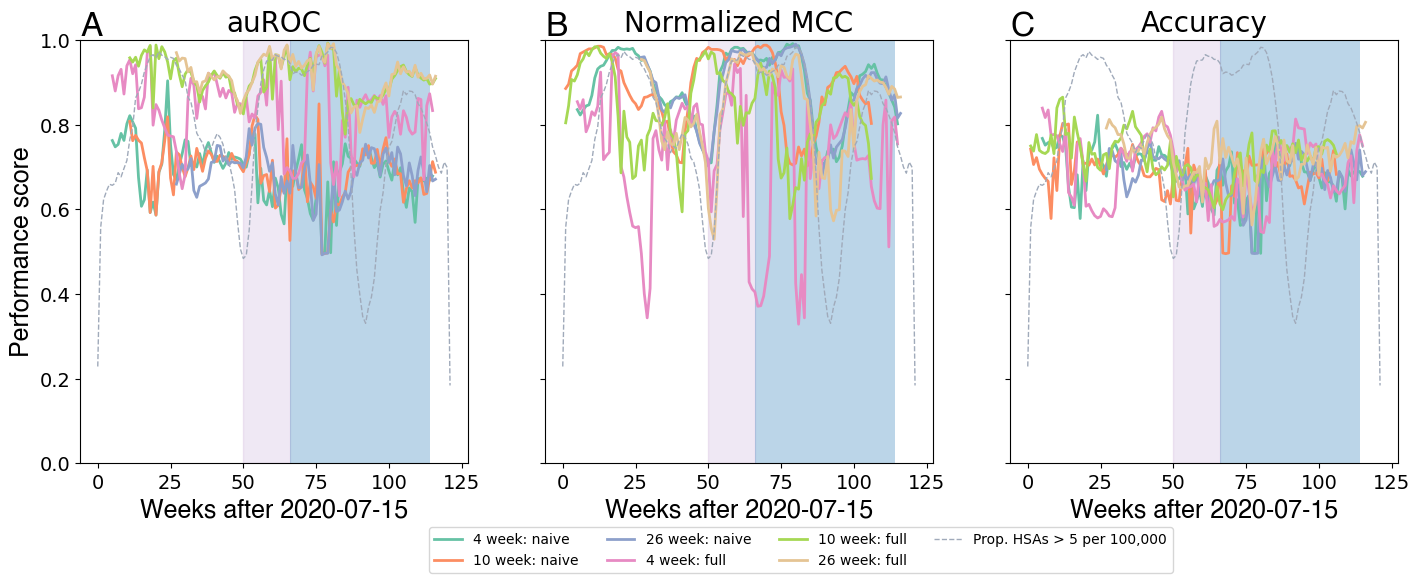

In [35]:
# Create a figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 5.5), sharey = 'all')

axs[0].plot(weeks_to_predict_four_week_graph,  model_metric_ROC['ROC_by_week_naive_4'], label='4 week: naive', linewidth = 2, color = palette[0])
axs[0].plot(weeks_to_predict_ten_week_graph, model_metric_ROC['ROC_by_week_naive_10'], label='10 week: naive', linewidth = 2, color = palette[1])
axs[0].plot(weeks_to_predict_twenty_six_week_graph,  model_metric_ROC['ROC_by_week_naive_26'], label='26 week: naive', linewidth = 2, color = palette[2])

axs[0].plot(weeks_to_predict_four_week_graph,  model_metric_ROC['ROC_by_week_full_period_4_week'], label='4 week: full', linewidth = 2, color = palette[3])
axs[0].plot(weeks_to_predict_ten_week_graph, model_metric_ROC['ROC_by_week_full_period_10_week'], label='10 week: full', linewidth = 2, color = palette[4])
axs[0].plot(weeks_to_predict_twenty_six_week_graph,  model_metric_ROC['ROC_by_week_full_period_26_week'], label='26 week: full', linewidth = 2, color = palette[5])

axs[0].set_title("auROC",fontsize=20)

axs[1].plot(weeks_to_predict_four_week_graph, model_metric_accuracy['accuracy_by_week_naive_4'], label='4 week: naive', linewidth = 2, color = palette[0])
axs[1].plot(weeks_to_predict_ten_week, model_metric_accuracy['accuracy_by_week_naive_10'], label='10 week: naive', linewidth = 2, color = palette[1])
axs[1].plot(weeks_to_predict_twenty_six_week_graph, model_metric_accuracy['accuracy_by_week_naive_26'], label='26 week: naive', linewidth = 2, color = palette[2])

axs[1].plot(weeks_to_predict_four_week_graph, model_metric_accuracy['accuracy_by_week_full_period_4_week'], label='4 week: full', linewidth = 2, color = palette[3])
axs[1].plot(weeks_to_predict_ten_week, model_metric_accuracy['accuracy_by_week_full_period_10_week'], label='10 week: full', linewidth = 2, color = palette[4])
axs[1].plot(weeks_to_predict_twenty_six_week_graph, model_metric_accuracy['accuracy_by_week_full_period_26_week'], label='26 week: full', linewidth = 2, color = palette[5])

axs[1].set_title("Normalized MCC",fontsize=20)


axs[2].plot(weeks_to_predict_four_week_graph, model_metric_MCC['norm_MCC_by_week_naive_4'], label='4 week: naive', linewidth = 2, color = palette[0])
axs[2].plot(weeks_to_predict_ten_week, model_metric_MCC['norm_MCC_by_week_naive_10'], label='10 week: naive', linewidth = 2, color = palette[1])
axs[2].plot(weeks_to_predict_twenty_six_week_graph, model_metric_MCC['norm_MCC_by_week_naive_26'], label='26 week: naive', linewidth = 2, color = palette[2])

axs[2].plot(weeks_to_predict_four_week_graph, model_metric_MCC['norm_MCC_by_week_full_period_4_week'], label='4 week: full', linewidth = 2, color = palette[3])
axs[2].plot(weeks_to_predict_ten_week, model_metric_MCC['norm_MCC_by_week_full_period_10_week'], label='10 week: full', linewidth = 2, color = palette[4])
axs[2].plot(weeks_to_predict_twenty_six_week_graph, model_metric_MCC['norm_MCC_by_week_full_period_26_week'], label='26 week: full', linewidth = 2, color = palette[5])

axs[2].set_title("Accuracy",fontsize=20)



# Add labels and legend
for i in range(len(axs)):
    axs[i].set_xlabel('Weeks after 2020-07-15',**hfont,  fontsize = 18 )
    axs[i].tick_params(axis='both', which='major', labelsize=14)
    polygon_delta = Polygon([(first_week_delta, 0), (first_week_delta, 100000), (last_week_delta, 100000), (last_week_delta, 0)],
                      alpha=0.3, color = '#cdb4db')
    axs[i].add_patch(polygon_delta)
    polygon_omricon = Polygon([(first_week_omricon, 0), (first_week_omricon, 100000), (last_week_omricon, 100000), (last_week_omricon, 0)],
                        alpha=0.3)
    axs[i].add_patch(polygon_omricon)
    axs[i].plot(range(0, len(percent_exceed_capacity)), percent_exceed_capacity, linewidth = 1, color = '#A0AABA', linestyle = '--', label = 'Prop. HSAs > 5 per 100,000')


axs[0].set_ylabel('Performance score',**hfont,  fontsize = 18)
axs[0].set_ylim(0,1)
#add_labels_to_subplots(axs, hfont, 1.01, 24)
axs[1].legend(ncol = 4, bbox_to_anchor=(-.3,-0.15),
                         loc='upper left', borderaxespad=0.)
add_labels_to_subplots(axs, hfont, 1.01, 24)

plt.savefig(f'/Users/rem76/Documents/COVID_projections/COVID_forecasting/Graphs/Performance_naive_and_full_train_models_shifted_different_training_sets_{size_of_test_dataset}_week_by_metric.png', dpi = 300, bbox_inches='tight' )